### 1. Importing Libraries

In [32]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 2. Loading Data

In [33]:
data = pd.read_table('../data/u.data')

In [34]:
data.head()

,user,event,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Pre-processing the data

#### 3.1 Finding all unique values from data for events and users

In [35]:
users = data['user'].unique()
events = data['event'].unique()

events[:10], users[:10]

(array([242, 302, 377,  51, 346, 474, 265, 465, 451,  86]),
 array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6]))

#### 3.2 Assigning idx's to unique users and events

In [36]:
user_to_idx = {user: idx for idx, user in enumerate(users)}
event_to_idx = {event: idx for idx, event in enumerate(events)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()} # For reverse lookup
idx_to_event = {idx: event for event, idx in event_to_idx.items()} # For reverse lookup

for key, value in user_to_idx.items():
    if value == 0:
        print(f'User: {key}, assigned index: {value}')

for key, value in event_to_idx.items():
    if value == 0:
        print(f'Event: {key}, assigned index: {value}')

User: 196, assigned index: 0
Event: 242, assigned index: 0


#### 3.3 Using the idx to add column in dataframe

In [37]:
data['user_idx'] = data['user'].map(user_to_idx)
data['event_idx'] = data['event'].map(event_to_idx)

data.head()

,user,event,rating,timestamp,user_idx,event_idx
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


#### 3.4 Splitting the data into training and testing

In [38]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=21, shuffle=True)
len(train_data), len(val_data), len(test_data)

(60000, 20000, 20000)

In [39]:
train_data.head()

,user,event,rating,timestamp,user_idx,event_idx
38585,519,878,5,884545961,521,995
57464,758,121,2,881978864,752,403
16125,277,872,3,879543768,261,223
16767,343,147,4,876402814,339,452
90032,686,50,4,879545413,684,357


In [40]:
test_data.head()

,user,event,rating,timestamp,user_idx,event_idx
39544,591,235,3,891039676,582,181
24258,450,689,3,882216026,442,890
23442,13,462,5,882140487,58,299
35853,159,1013,4,880557170,233,1013
35928,515,307,4,887659123,507,104


#### 3.5 Creating the train and test dataloaders

In [41]:
train_dataloader = DataLoader(train_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)

In [42]:
for batch in train_dataloader:
    print('Example batch: ', batch[:10])
    print()
    print('Len of a batch: ', len(batch))
    break

Example batch:  tensor([[524, 746,   3],
        [130, 656,   5],
        [ 70, 394,   3],
        [859, 594,   3],
        [369, 740,   3],
        [446, 506,   3],
        [335, 180,   5],
        [ 70, 705,   4],
        [181, 773,   3],
        [584, 969,   5]])

Len of a batch:  64


### 4. Defining the model

The `NCF` (Neural Collaborative Filtering) model is a class that inherits from the `nn.Module` class in PyTorch, making it a neural network model. This model is designed for collaborative filtering tasks, which involve predicting user preferences or recommendations based on user-item interactions. 

- In the `__init__` method, the model initializes its layers and parameters. It takes in the number of users, number of items, embedding dimension, and hidden dimension as input arguments. It creates two embedding layers, `user_embedding` and `item_embedding`, which are used to learn low-dimensional representations of users and items. These embeddings capture the latent features of users and items that are relevant for making predictions. The size of the embeddings is determined by the `embedding_dim` parameter.

- The model also includes two fully connected layers, `fc1` and `fc2`, which are used for non-linear transformations and prediction. The input to `fc1` is the concatenation of the user and item embeddings, resulting in a tensor with a size of `embedding_dim * 2`. The output of `fc1` is passed through a rectified linear unit (ReLU) activation function using the `F.relu` function from PyTorch. Finally, the output of `fc1` is fed into `fc2`, which produces a single output representing the predicted rating or preference.

- The `forward` method defines the forward pass of the model. Given a user tensor and an item tensor as input, it retrieves the corresponding user and item embeddings using the embedding layers. These embeddings are then concatenated along the last dimension using the `torch.cat` function. The concatenated tensor is passed through `fc1`, followed by the ReLU activation function. The resulting tensor is then passed through `fc2` to obtain the final prediction.

- Overall, the `NCF` model combines user and item embeddings with non-linear transformations to learn the underlying patterns and relationships in user-item interactions, enabling it to make accurate predictions for collaborative filtering tasks.The `NCF` (Neural Collaborative Filtering) model is a class that inherits from the `nn.Module` class in PyTorch, making it a neural network model. This model is designed for collaborative filtering tasks, which involve predicting user preferences or recommendations based on user-item interactions. 

- In the `__init__` method, the model initializes its layers and parameters. It takes in the number of users, number of items, embedding dimension, and hidden dimension as input arguments. It creates two embedding layers, `user_embedding` and `item_embedding`, which are used to learn low-dimensional representations of users and items. These embeddings capture the latent features of users and items that are relevant for making predictions. The size of the embeddings is determined by the `embedding_dim` parameter.

- The model also includes two fully connected layers, `fc1` and `fc2`, which are used for non-linear transformations and prediction. The input to `fc1` is the concatenation of the user and item embeddings, resulting in a tensor with a size of `embedding_dim * 2`. The output of `fc1` is passed through a rectified linear unit (ReLU) activation function using the `F.relu` function from PyTorch. Finally, the output of `fc1` is fed into `fc2`, which produces a single output representing the predicted rating or preference.

- The `forward` method defines the forward pass of the model. Given a user tensor and an item tensor as input, it retrieves the corresponding user and item embeddings using the embedding layers. These embeddings are then concatenated along the last dimension using the `torch.cat` function. The concatenated tensor is passed through `fc1`, followed by the ReLU activation function. The resulting tensor is then passed through `fc2` to obtain the final prediction.

Overall, the `NCF` model combines user and item embeddings with non-linear transformations to learn the underlying patterns and relationships in user-item interactions, enabling it to make accurate predictions for collaborative filtering tasks.

In [43]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=96, hidden_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, user, item):
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)
        x = torch.cat([user_embedded, item_embedded], dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### 5. Defining the hyperparamters

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_users = len(users)
num_events = len(events)
model = NCF(num_users, num_events).to(device)
num_epochs = 10
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=10)

In [46]:
def train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=10):
    train_losses = []
    val_losses = []
    train_mae = []
    val_mae = []
    train_rmse = []
    val_rmse = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_mae = 0

        for batch in train_dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            optimizer.zero_grad()
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(output - target)).item()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_mae = total_mae / len(train_dataloader)
        avg_train_rmse = np.sqrt(avg_train_loss)

        train_losses.append(avg_train_loss)
        train_mae.append(avg_train_mae)
        train_rmse.append(avg_train_rmse)

        # Validation Loop
        model.eval()  # Set model to evaluation mode for validation
        total_val_loss = 0
        total_val_mae = 0
        with torch.no_grad():
            for batch in val_dataloader:
                user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
                output = model(user, event).squeeze()
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()
                total_val_mae += torch.mean(torch.abs(output - target)).item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_mae = total_val_mae / len(val_dataloader)
        avg_val_rmse = np.sqrt(avg_val_loss)

        val_losses.append(avg_val_loss)
        val_mae.append(avg_val_mae)
        val_rmse.append(avg_val_rmse)

        print(f'Epoch: {epoch+1} -> MSE Loss: {avg_train_loss} | RMSE: {avg_train_rmse} | MAE: {avg_train_mae} | Val Loss: {avg_val_loss} | Val RMSE: {avg_val_rmse} | Val MAE: {avg_val_mae}')

        if early_stopper.early_stop(avg_val_loss):
            break

    return train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse

In [47]:
train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs)

Epoch: 1 -> MSE Loss: 1.7296721749087132 | RMSE: 1.315170017491546 | MAE: 1.0159532945674619 | Val Loss: 1.0675845500379324 | Val RMSE: 1.033239831809601 | Val MAE: 0.825994502050808
Epoch: 2 -> MSE Loss: 0.9656026279494199 | RMSE: 0.9826508168975487 | MAE: 0.7841938631748085 | Val Loss: 1.001631737707522 | Val RMSE: 1.0008155363040294 | Val MAE: 0.7933890811932354
Epoch: 3 -> MSE Loss: 0.8873884684876847 | RMSE: 0.9420129874304731 | MAE: 0.7478586972268151 | Val Loss: 0.9765053926565396 | Val RMSE: 0.9881828740959537 | Val MAE: 0.7892497412312907
Epoch: 4 -> MSE Loss: 0.8406053054561493 | RMSE: 0.9168453007220735 | MAE: 0.7260907484270108 | Val Loss: 0.9702255409746505 | Val RMSE: 0.9850002746063833 | Val MAE: 0.7801661076256261
Epoch: 5 -> MSE Loss: 0.8023197339224154 | RMSE: 0.8957230229945055 | MAE: 0.7088186106702158 | Val Loss: 0.9701757303442056 | Val RMSE: 0.9849749897049191 | Val MAE: 0.7794256410278833


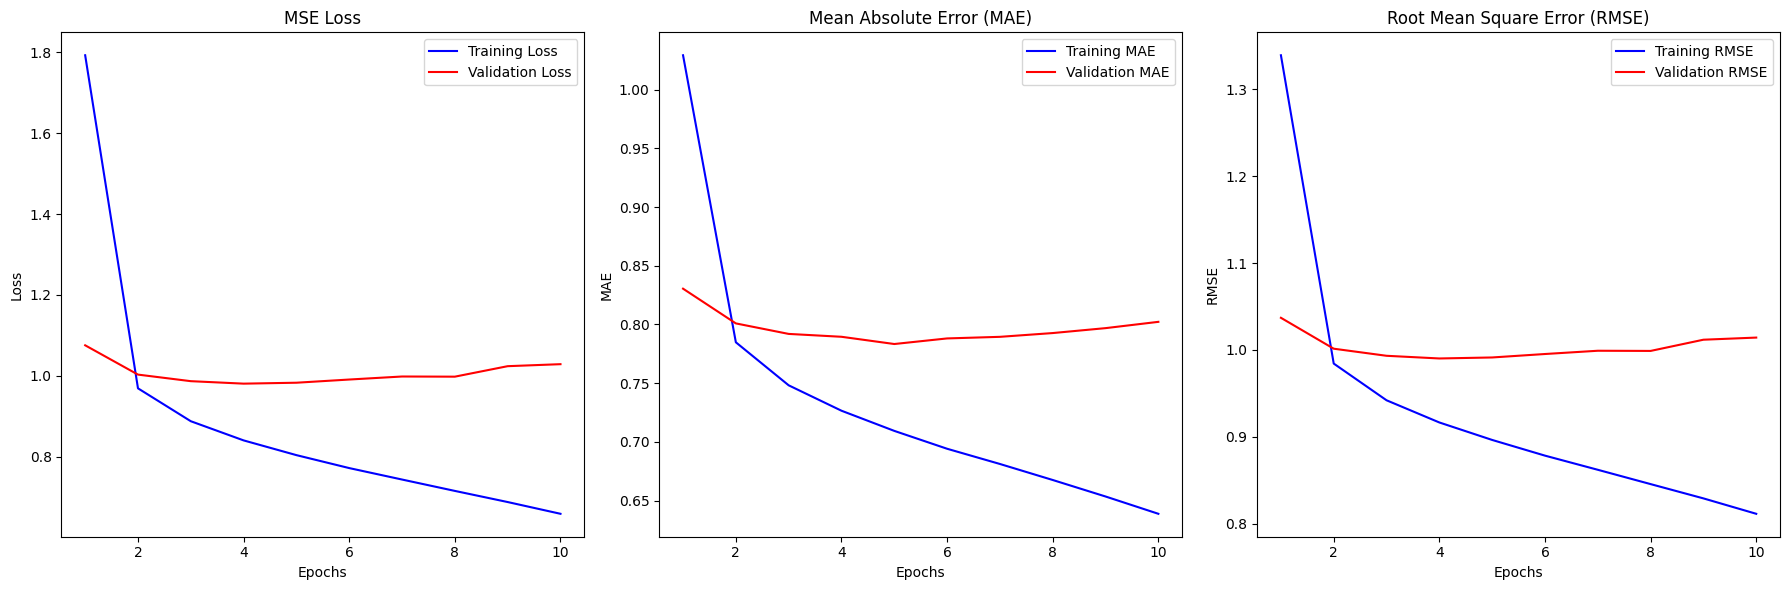

In [ ]:
# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 6))

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse, 'b', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Root Mean Square Error (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
sample = [808, 881]
user = torch.tensor([user_to_idx[sample[0]]]).to(device)
event = torch.tensor([event_to_idx[sample[1]]]).to(device)
model.eval()
model(user, event)

tensor([[3.7128]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_mae = 0
    with torch.no_grad():
        for batch in dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(output - target)).item()
    
    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / len(dataloader)
    avg_rmse = np.sqrt(avg_loss)
    
    print(f'Test Loss: {avg_loss} | Test RMSE: {avg_rmse} | Test MAE: {avg_mae}')
    
    return avg_loss, avg_rmse, avg_mae

In [ ]:
test_loss, test_rmse, test_mae = evaluate(model, test_dataloader, criterion, device)

Test Loss: 1.0192446440172653 | Test RMSE: 1.00957646764238 | Test MAE: 0.7998171880984077
